In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import shutil
import keras_tuner as kt
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
TICKER = "INDF"
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,6016.364746,6016.364746,5930.722543,5994.954195,2961000,0.131148
2022-07-12,6037.774414,6080.595509,5973.542771,6037.774414,5209400,0.205047
2022-07-13,5845.080078,5994.953926,5823.669528,5994.953926,10978800,0.204082
2022-07-14,5930.722168,5952.132717,5823.669421,5845.079971,7611600,0.259887
2022-07-15,5909.312500,5952.133605,5845.080842,5930.723053,4235000,0.334204
...,...,...,...,...,...,...
2025-07-25,8400.000000,8400.000000,8300.000000,8350.000000,3388300,-0.212928
2025-07-28,8375.000000,8475.000000,8350.000000,8475.000000,3305800,-0.064327
2025-07-29,8300.000000,8400.000000,8275.000000,8350.000000,3728500,-0.176030


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-07-11 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           732 non-null    float64
 1   High            732 non-null    float64
 2   Low             732 non-null    float64
 3   Open            732 non-null    float64
 4   Volume          732 non-null    int64  
 5   nilai_sentimen  732 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [ ]:
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,6016.364746,6016.364746,5930.722543,5994.954195,2961000,0.131148
2022-07-12,6037.774414,6080.595509,5973.542771,6037.774414,5209400,0.205047
2022-07-13,5845.080078,5994.953926,5823.669528,5994.953926,10978800,0.204082
2022-07-14,5930.722168,5952.132717,5823.669421,5845.079971,7611600,0.259887
2022-07-15,5909.312500,5952.133605,5845.080842,5930.723053,4235000,0.334204
...,...,...,...,...,...,...
2025-07-25,8400.000000,8400.000000,8300.000000,8350.000000,3388300,-0.212928
2025-07-28,8375.000000,8475.000000,8350.000000,8475.000000,3305800,-0.064327
2025-07-29,8300.000000,8400.000000,8275.000000,8350.000000,3728500,-0.176030


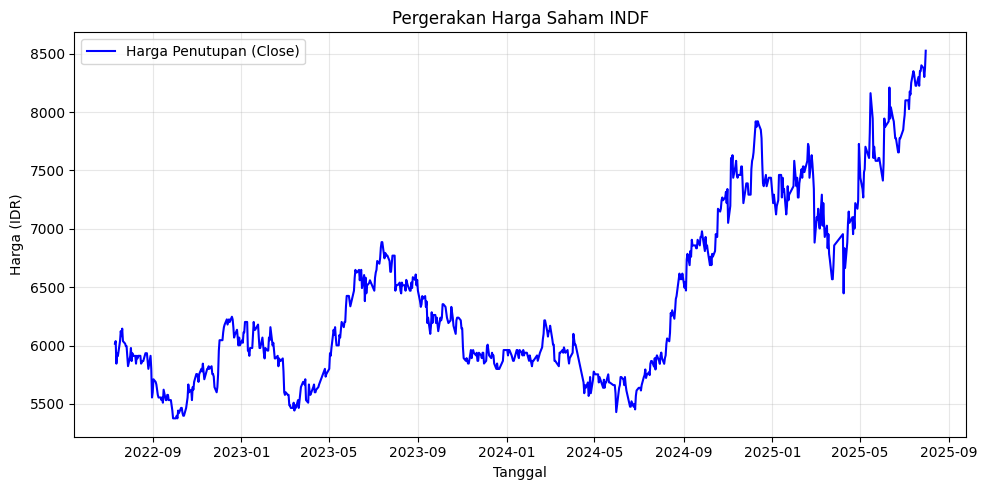

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,6016.364746,2961000,0.131148
2022-07-12,6037.774414,5209400,0.205047
2022-07-13,5845.080078,10978800,0.204082
2022-07-14,5930.722168,7611600,0.259887
2022-07-15,5909.312500,4235000,0.334204
...,...,...,...
2025-07-25,8400.000000,3388300,-0.212928
2025-07-28,8375.000000,3305800,-0.064327
2025-07-29,8300.000000,3728500,-0.176030


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
print("Train samples:", X_train.shape[0], "val samples:", X_val.shape[0])

Train samples: 520 val samples: 131


In [ ]:
joblib.dump(scaler, f"./data/{TICKER}/scaler_sentimen.pkl")

['./data/INDF/scaler_sentimen.pkl']

## Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
## Reset/Ulang Tuning

# tuning_dir = f'model/{TICKER}/{TICKER}_lstm_tuning'

# if os.path.exists(tuning_dir):
#     shutil.rmtree(tuning_dir)

### persiapan

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
earlystop = callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

###LSTM

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('lstm_units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('lstm_units2', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.LSTM(hp_units1, return_sequences=True),
        layers.LSTM(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=80,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_lstm_tuning'
)

Reloading Tuner from model/INDF/INDF_lstm_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 80 Complete [00h 00m 06s]
val_root_mean_squared_error: 0.16705165803432465

Best val_root_mean_squared_error So Far: 0.1229986622929573
Total elapsed time: 32d 00h 33m 14s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'lstm_units1': 64, 'lstm_units2': 16, 'dropout_rate': 0.2, 'dense_units': 64}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,110 (98.09 KB)

 Trainable params: 25,110 (98.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,110 (98.09 KB)

 Trainable params: 25,110 (98.09 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = lstm_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 0s - 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432
Epoch 2/100
21/21 - 1s - 27ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 3/100
21/21 - 0s - 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402
Epoch 4/100
21/21 - 0s - 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398
Epoch 5/100
21/21 - 0s - 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394
Epoch 6/100
21/21 - 0s - 10ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390
Epoch 7/100
21/21 - 0s - 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388
Epoch 8/100
21/21 - 0s - 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393
Epoch 9/100
21/21 - 0s - 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390
Epoch 10/100
21/21 - 0s - 10ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384
Epoch 11/100
21/21 - 0s - 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395
Epoch 12/100
21/21 - 0s - 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0

In [ ]:
eval_results = lstm_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.013977725990116596, 0.11822742968797684]


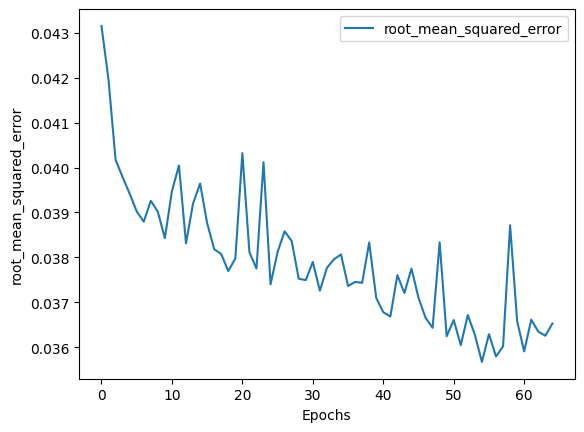

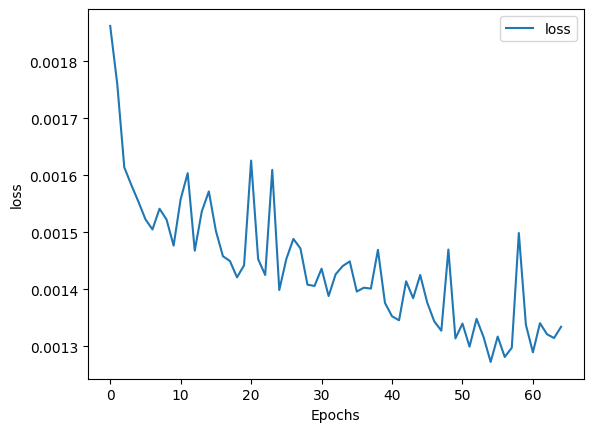

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = lstm_model.predict(X_train)
val_pred = lstm_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(lstm_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediksi 22 hari ke depan (close):
[7307.98253052 7369.26955727 7381.94533497 7397.47788233 7318.30278219
 7379.79642414 7309.46242842 7263.77625779 7279.31612395 7265.41529256
 7247.70249492 7151.65325597 7148.97457698 7094.98232463 7130.20336898
 7049.57802144 7012.65845366 6879.64254391 6904.92879314 6909.92058669
 6841.50467825 6834.64368321]


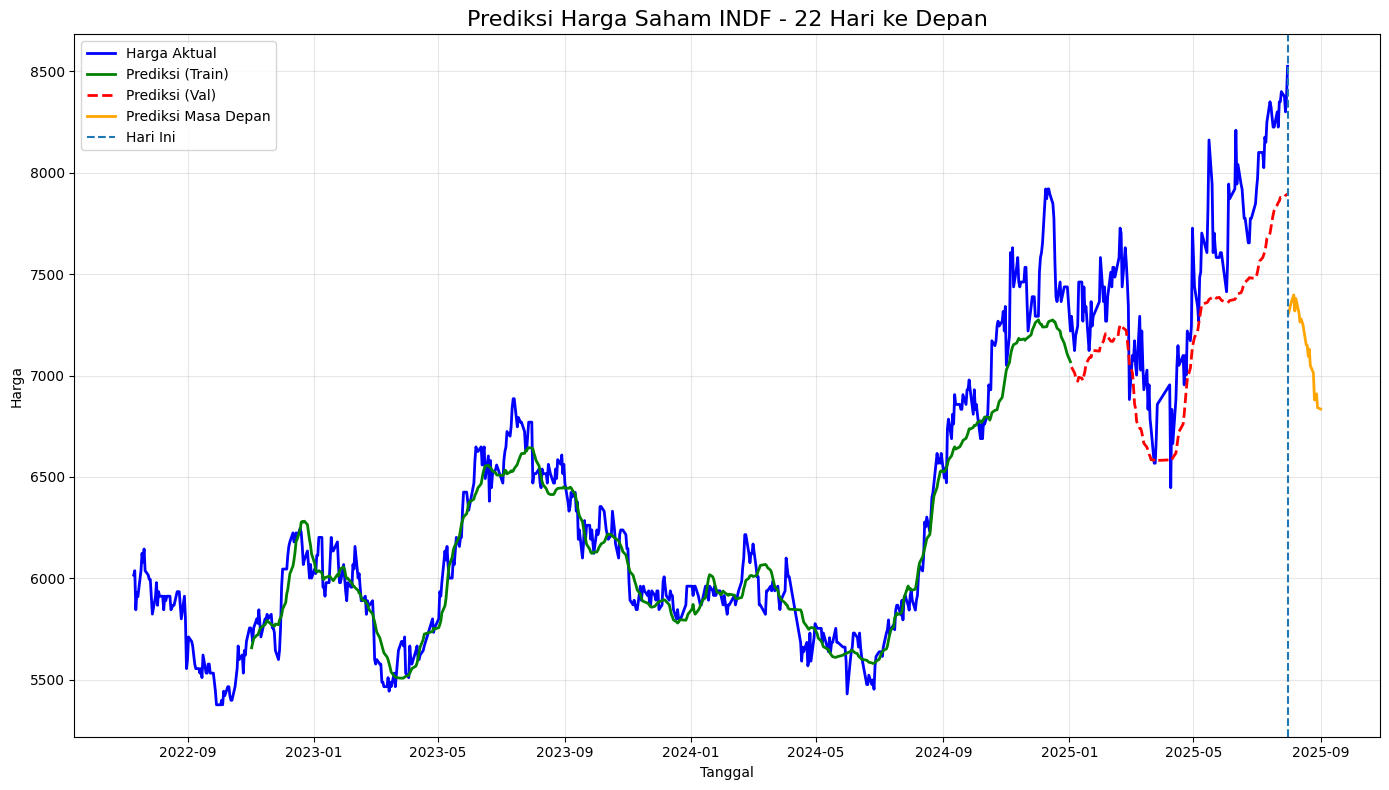

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
lstm_model.save(f"./model/{TICKER}/sentimen_lstm_model.keras")
lstm_model.save(f"./model/{TICKER}/sentimen_lstm_model.h5")

### BiLSTM

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('bilstm_units', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.Bidirectional(layers.LSTM(hp_units1, return_sequences=True)),
        layers.LSTM(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=60,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_bilstm_tuning'
)

Reloading Tuner from model/INDF/INDF_bilstm_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 60 Complete [00h 00m 08s]
val_root_mean_squared_error: 0.14833661913871765

Best val_root_mean_squared_error So Far: 0.1123911514878273
Total elapsed time: 32d 01h 33m 57s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'bilstm_units': 128, 'lstm_units': 80, 'dropout_rate': 0.1, 'dense_units': 16}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80)             │       107,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,678 (955.77 KB)

 Trainable params: 244,678 (955.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bilstm_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 60, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80)             │       107,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │           374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,678 (955.77 KB)

 Trainable params: 244,678 (955.77 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = bilstm_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 3s - 130ms/step - loss: 0.1071 - root_mean_squared_error: 0.3272
Epoch 2/100
21/21 - 0s - 14ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534
Epoch 3/100
21/21 - 0s - 14ms/step - loss: 0.0400 - root_mean_squared_error: 0.2000
Epoch 4/100
21/21 - 0s - 14ms/step - loss: 0.0246 - root_mean_squared_error: 0.1567
Epoch 5/100
21/21 - 0s - 15ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266
Epoch 6/100
21/21 - 0s - 19ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085
Epoch 7/100
21/21 - 1s - 30ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955
Epoch 8/100
21/21 - 0s - 20ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923
Epoch 9/100
21/21 - 0s - 19ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876
Epoch 10/100
21/21 - 0s - 18ms/step - loss: 0.0072 - root_mean_squared_error: 0.0851
Epoch 11/100
21/21 - 0s - 20ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842
Epoch 12/100
21/21 - 0s - 23ms/step - loss: 0.0068 - root_mean_squared_er

In [ ]:
eval_results = bilstm_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.002488203812390566, 0.04988189786672592]


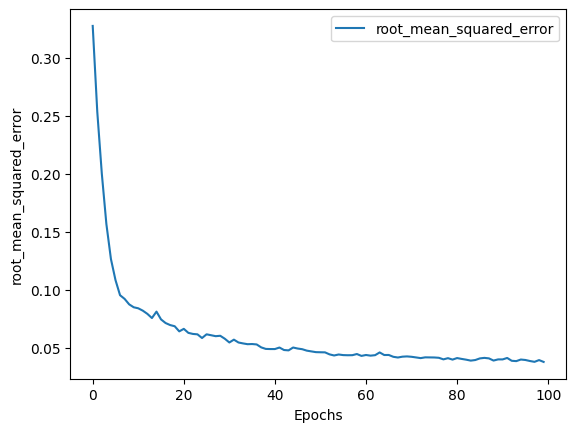

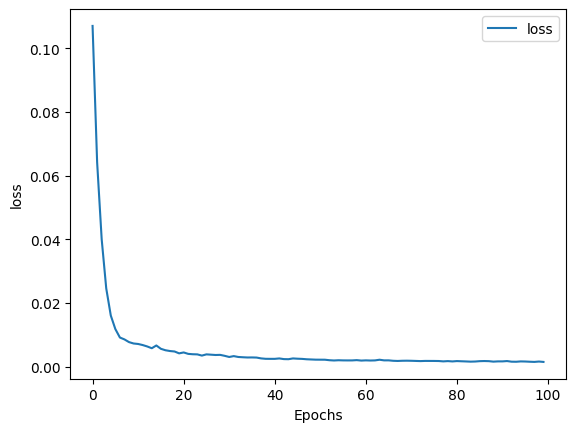

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = bilstm_model.predict(X_train)
val_pred = bilstm_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
pred_22 = tsp.predict_next_days(bilstm_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediksi 22 hari ke depan (close):
[8184.38740704 8206.77147254 8233.17543314 8286.4318651  8278.27891508
 8319.19323133 8364.57951902 8405.76688262 8453.31728171 8433.72449204
 8431.06382855 8455.51779942 8493.849144   8541.0123976  8567.6697011
 8527.97030482 8580.78948569 8485.8322485  8560.1692498  8521.30044293
 8591.19343435 8592.51419536]


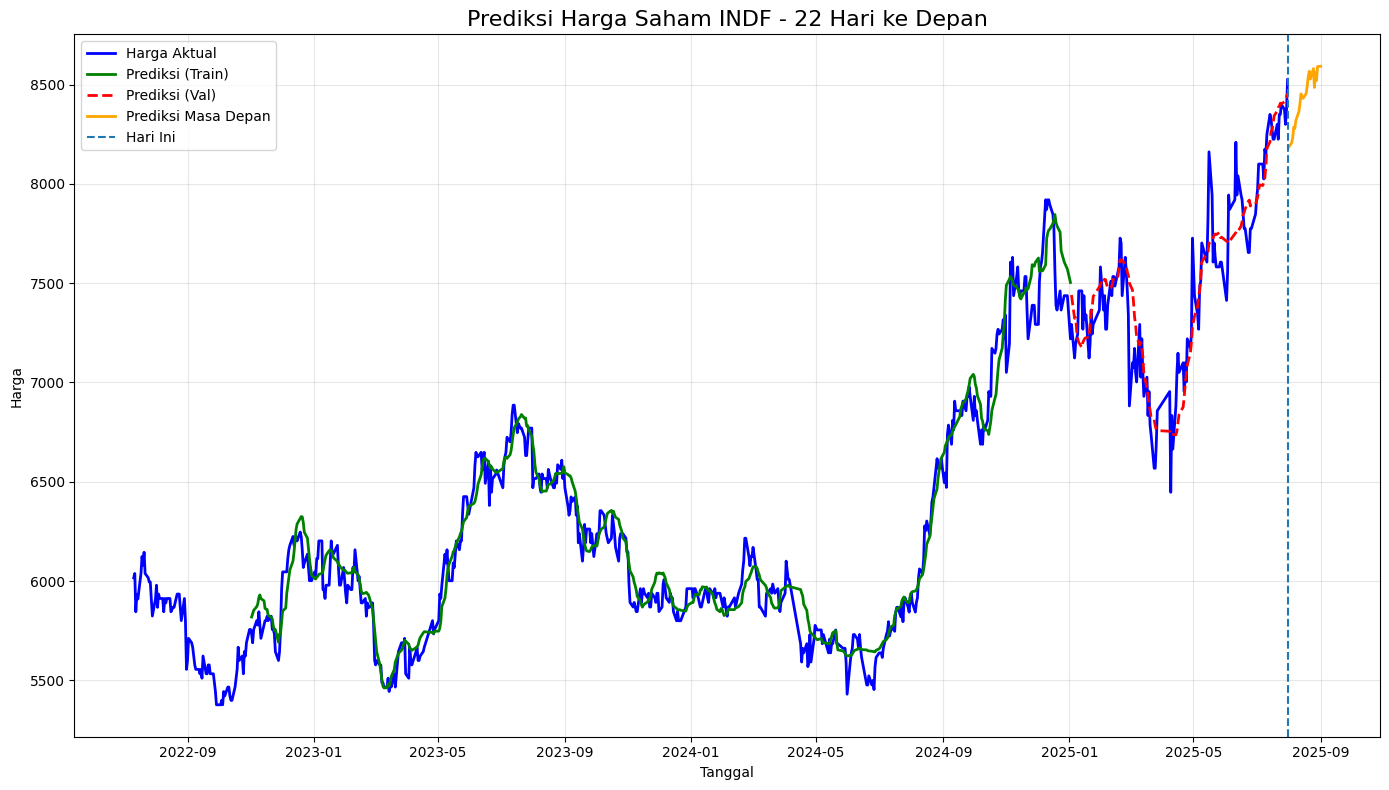

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
bilstm_model.save(f"./model/{TICKER}/sentimen_bilstm_model.keras")
bilstm_model.save(f"./model/{TICKER}/sentimen_bilstm_model.h5")

### GRU

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('gru_units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('gru_units2', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.GRU(hp_units1, return_sequences=True),
        layers.GRU(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=30,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_gru_tuning'
)

Reloading Tuner from model/INDF/INDF_gru_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'gru_units1': 96, 'gru_units2': 128, 'dropout_rate': 0.4, 'dense_units': 48}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 96)         │        29,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        86,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,142 (481.02 KB)

 Trainable params: 123,142 (481.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 96)         │        29,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        86,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,142 (481.02 KB)

 Trainable params: 123,142 (481.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = gru_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 2s - 94ms/step - loss: 0.0876 - root_mean_squared_error: 0.2960
Epoch 2/100
21/21 - 0s - 11ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479
Epoch 3/100
21/21 - 0s - 10ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 4/100
21/21 - 0s - 10ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055
Epoch 5/100
21/21 - 0s - 11ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062
Epoch 6/100
21/21 - 0s - 10ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019
Epoch 7/100
21/21 - 0s - 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1012
Epoch 8/100
21/21 - 0s - 10ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977
Epoch 9/100
21/21 - 0s - 9ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948
Epoch 10/100
21/21 - 0s - 9ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962
Epoch 11/100
21/21 - 0s - 9ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978
Epoch 12/100
21/21 - 0s - 10ms/step - loss: 0.0086 - root_mean_squared_error:

In [ ]:
eval_results = gru_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.003655168926343322, 0.060457993298769]


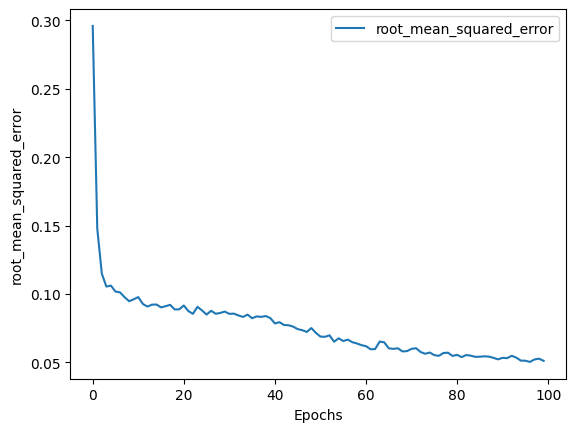

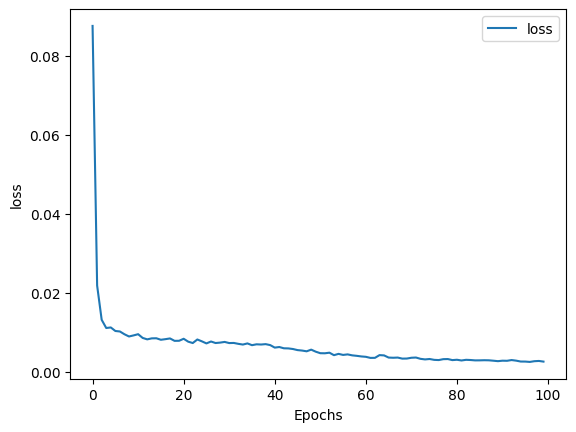

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = gru_model.predict(X_train)
val_pred = gru_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(gru_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediksi 22 hari ke depan (close):
[8305.95221746 8341.22336741 8285.19236147 8167.12368315 8141.5705794
 8191.99313639 8179.36802727 8109.74226571 8047.06673218 8115.9501052
 8049.55756209 8068.80805735 8040.56182467 8033.28112489 7986.75667075
 7942.58023618 7919.03417122 7924.2971355  7834.1408402  7756.81326665
 7839.5618154  7735.52364251]


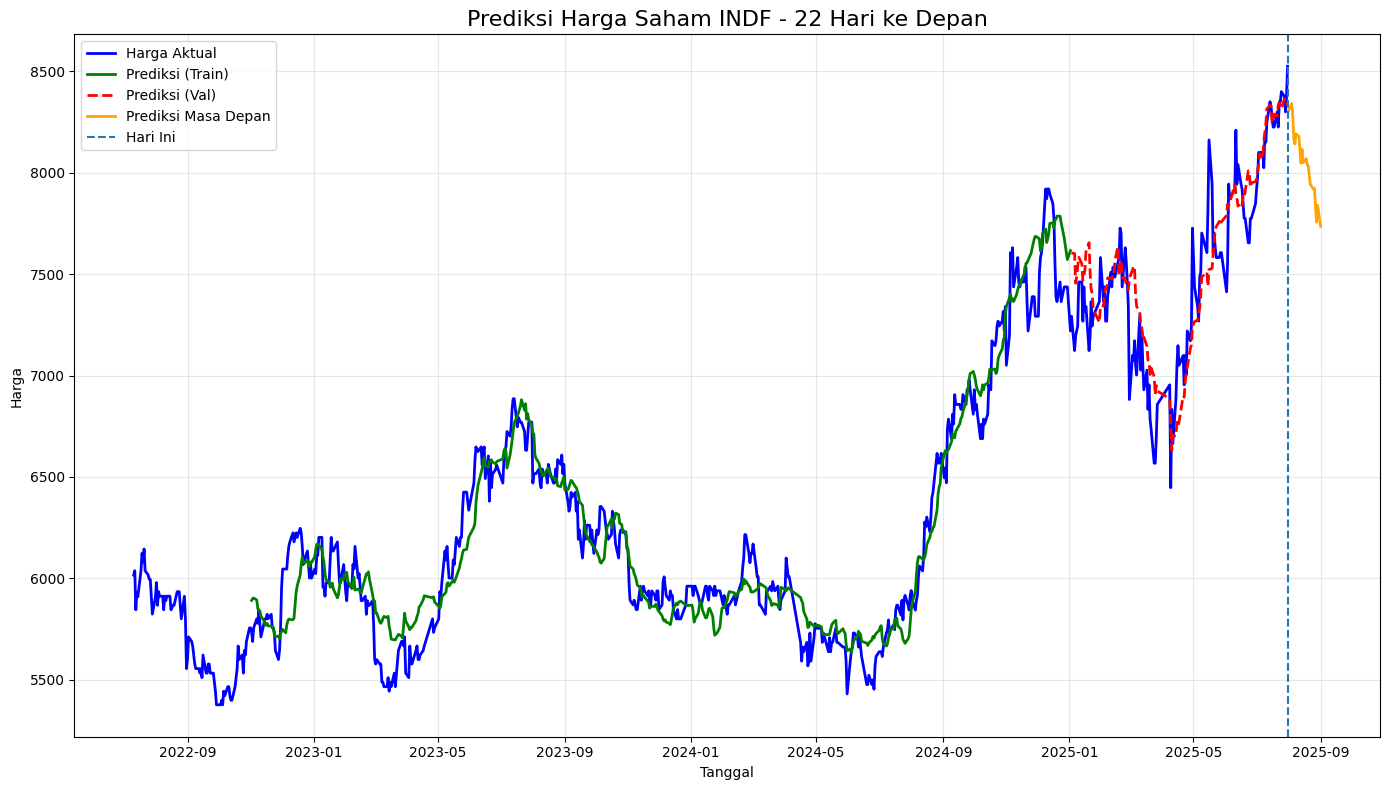

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
gru_model.save(f"./model/{TICKER}/sentimen_gru_model.keras")
gru_model.save(f"./model/{TICKER}/sentimen_gru_model.h5")